In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=4c1e4b59cb321b8a1842347b86310cf4d5cd8bf7b398923e5eeaa77145c93a33
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, isnull

In [ ]:
spark = SparkSession.builder \
.appName("Kitap Oneri Sistemi") \
.getOrCreate()

In [ ]:
df = spark.read.csv("books.csv", header = True , inferSchema= True)

In [ ]:
df.show(10)

+-------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+---------------+--------------------+
|Book Id|               Title|              Author|average_rating|      isbn|       isbn13|language_code|num_pages|ratings_count|text_reviews_count|publication_date|      publisher|              genres|
+-------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+---------------+--------------------+
|      1|Harry Potter and ...|J.K. Rowling/Mary...|          4.57|0439785960|9780439785969|          eng|      652|      2095690|             27591|       9/16/2006|Scholastic Inc.|Fantasy;Young Adu...|
|      2|Harry Potter and ...|J.K. Rowling/Mary...|          4.49|0439358078|9780439358071|          eng|      870|      2153167|             29221|        9/1/2004|Scholastic Inc.|Fantasy

In [ ]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+-------+-----+------+--------------+----+------+-------------+---------+-------------+------------------+----------------+---------+------+
|Book Id|Title|Author|average_rating|isbn|isbn13|language_code|num_pages|ratings_count|text_reviews_count|publication_date|publisher|genres|
+-------+-----+------+--------------+----+------+-------------+---------+-------------+------------------+----------------+---------+------+
|      0|    0|     0|             0|   0|     0|            0|        0|            0|                 0|               0|        0|    97|
+-------+-----+------+--------------+----+------+-------------+---------+-------------+------------------+----------------+---------+------+



In [ ]:
from pyspark.sql.functions import col, month, year, length

In [ ]:
df = df.filter(col("genres").isNotNull())

In [ ]:
df = df.withColumn("rating_ratio", col("average_rating") / col("ratings_count"))

In [ ]:
from pyspark.sql.functions import to_date, month, year

In [ ]:
df = df.withColumn("publication_date", to_date(df["publication_date"], "M/d/yyyy"))

In [ ]:
df = df.withColumn("publication_month", month("publication_date"))
df = df.withColumn("publication_year", year("publication_date"))

In [ ]:
df.show()

+-------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+--------------------+--------------------+--------------------+-----------------+----------------+
|Book Id|               Title|              Author|average_rating|      isbn|       isbn13|language_code|num_pages|ratings_count|text_reviews_count|publication_date|           publisher|              genres|        rating_ratio|publication_month|publication_year|
+-------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+--------------------+--------------------+--------------------+-----------------+----------------+
|      1|Harry Potter and ...|J.K. Rowling/Mary...|          4.57|0439785960|9780439785969|          eng|      652|      2095690|             27591|      2006-09-16|     Scholastic Inc.|Fantasy;Young Adu...|2

In [ ]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="genres", outputCol="categoryIndex")
df = indexer.fit(df).transform(df)

In [ ]:
indexer1 = StringIndexer(inputCol="Author", outputCol="AuthorIndex")
df = indexer1.fit(df).transform(df)

In [ ]:
df.show(10)

+-------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+---------------+--------------------+--------------------+-----------------+----------------+-------------+-----------+
|Book Id|               Title|              Author|average_rating|      isbn|       isbn13|language_code|num_pages|ratings_count|text_reviews_count|publication_date|      publisher|              genres|        rating_ratio|publication_month|publication_year|categoryIndex|AuthorIndex|
+-------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+---------------+--------------------+--------------------+-----------------+----------------+-------------+-----------+
|      1|Harry Potter and ...|J.K. Rowling/Mary...|          4.57|0439785960|9780439785969|          eng|      652|      2095690|             275

In [ ]:
from pyspark.sql.functions import col, concat_ws

df = df.withColumn("publication_month", month(col("publication_date")))
df = df.withColumn("publication_year", year(col("publication_date")))
df = df.withColumn("title_length", length(col("title")))
df.show(5)

+-------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+---------------+--------------------+--------------------+-----------------+----------------+-------------+-----------+------------+
|Book Id|               Title|              Author|average_rating|      isbn|       isbn13|language_code|num_pages|ratings_count|text_reviews_count|publication_date|      publisher|              genres|        rating_ratio|publication_month|publication_year|categoryIndex|AuthorIndex|title_length|
+-------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+---------------+--------------------+--------------------+-----------------+----------------+-------------+-----------+------------+
|      1|Harry Potter and ...|J.K. Rowling/Mary...|          4.57|0439785960|9780439785969|          eng| 

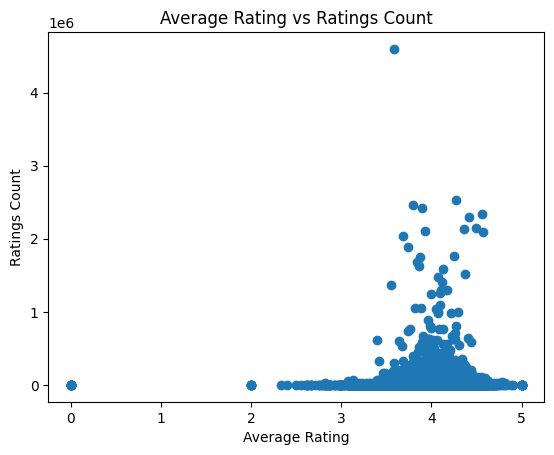

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
average_ratings = np.array(df.select("average_rating").collect()).flatten()
ratings_count = np.array(df.select("ratings_count").collect()).flatten()
plt.scatter(average_ratings, ratings_count)
plt.xlabel("Average Rating")
plt.ylabel("Ratings Count")
plt.title("Average Rating vs Ratings Count")
plt.show()

In [ ]:
from pyspark.sql.functions import split

In [ ]:
df = df.select([col(col_name).alias(col_name.strip()) for col_name in df.columns])

df = df.withColumn("num_pages", df["num_pages"].cast("integer"))

df.filter(col("publication_date").isNull()).show()

df = df.na.drop(subset=["publication_date"])

+-------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+--------------+--------------------+--------------------+-----------------+----------------+-------------+-----------+------------+
|Book Id|               Title|              Author|average_rating|      isbn|       isbn13|language_code|num_pages|ratings_count|text_reviews_count|publication_date|     publisher|              genres|        rating_ratio|publication_month|publication_year|categoryIndex|AuthorIndex|title_length|
+-------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+--------------+--------------------+--------------------+-----------------+----------------+-------------+-----------+------------+
|  31373|In Pursuit of the...|   Elizabeth  George|           4.1|0553575104|9780553575101|          eng|    

In [ ]:
df.show()

+-------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+--------------------+--------------------+--------------------+-----------------+----------------+-------------+-----------+------------+
|Book Id|               Title|              Author|average_rating|      isbn|       isbn13|language_code|num_pages|ratings_count|text_reviews_count|publication_date|           publisher|              genres|        rating_ratio|publication_month|publication_year|categoryIndex|AuthorIndex|title_length|
+-------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+--------------------+--------------------+--------------------+-----------------+----------------+-------------+-----------+------------+
|      1|Harry Potter and ...|J.K. Rowling/Mary...|          4.57|0439785960|9780439785969|

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml.linalg import Vectors

In [ ]:
all_feature_cols = ["average_rating", "ratings_count",
                     "categoryIndex","AuthorIndex"]


In [ ]:
df = df.withColumn("average_rating", col("average_rating").cast("float"))

In [ ]:
vector_assembler_all = VectorAssembler(inputCols=all_feature_cols, outputCol="all_features", handleInvalid="skip")
df_assembled_all = vector_assembler_all.transform(df)

In [ ]:
normalizer_all = Normalizer(inputCol="all_features", outputCol="norm_all_features", p=2.0)
df_normalized_all = normalizer_all.transform(df_assembled_all)

In [ ]:
df_normalized_all.select("all_features", "norm_all_features").show(5, truncate=False)

+-----------------------------------------+--------------------------------------------------------------------------------------+
|all_features                             |norm_all_features                                                                     |
+-----------------------------------------+--------------------------------------------------------------------------------------+
|[4.570000171661377,2095690.0,59.0,256.0] |[2.1806660983937316E-6,0.9999999921403466,2.8153018593532655E-5,1.2215547050753152E-4]|
|[4.489999771118164,2153167.0,59.0,256.0] |[2.0853002752167354E-6,0.9999999925544379,2.7401497218149748E-5,1.1889463199739552E-4]|
|[4.420000076293945,6333.0,90.0,66.0]     |[6.97822959136768E-4,0.9998445076767126,0.01420906453353926,0.010419980657928792]     |
|[4.559999942779541,2339585.0,137.0,256.0]|[1.9490635765122607E-6,0.9999999922971262,5.8557393274750136E-5,1.0942111444040901E-4]|
|[4.78000020980835,41428.0,2943.0,256.0]  |[1.150886807194625E-4,0.9974672919600264

In [ ]:
df_normalized_all.show(10)

+-------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+---------------+--------------------+--------------------+-----------------+----------------+-------------+-----------+------------+--------------------+--------------------+
|Book Id|               Title|              Author|average_rating|      isbn|       isbn13|language_code|num_pages|ratings_count|text_reviews_count|publication_date|      publisher|              genres|        rating_ratio|publication_month|publication_year|categoryIndex|AuthorIndex|title_length|        all_features|   norm_all_features|
+-------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+---------------+--------------------+--------------------+-----------------+----------------+-------------+-----------+------------+--------------------+--

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pandas_df = df_normalized_all.select("genres").toPandas()

category_counts = pandas_df["genres"].value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Kategorilere Göre Kitap Sayısı')
plt.xlabel('Kategori')
plt.ylabel('Kitap Sayısı')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7ed615f09000> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ed615f08280> (for post_execute):


KeyboardInterrupt: 

In [ ]:
train_data, test_data = df_normalized_all.randomSplit([0.8, 0.2], seed=42)

In [ ]:
train_data.count()

8891

In [ ]:
test_data.count()

2137

In [ ]:
df.show()

+-------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+--------------------+--------------------+--------------------+-----------------+----------------+-------------+-----------+------------+
|Book Id|               Title|              Author|average_rating|      isbn|       isbn13|language_code|num_pages|ratings_count|text_reviews_count|publication_date|           publisher|              genres|        rating_ratio|publication_month|publication_year|categoryIndex|AuthorIndex|title_length|
+-------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+--------------------+--------------------+--------------------+-----------------+----------------+-------------+-----------+------------+
|      1|Harry Potter and ...|J.K. Rowling/Mary...|          4.57|0439785960|9780439785969|

In [ ]:
from pyspark.ml.feature import BucketedRandomProjectionLSH

In [ ]:
lsh = BucketedRandomProjectionLSH(inputCol="norm_all_features", outputCol="hashes", bucketLength=10.0, numHashTables=5)

In [ ]:
lsh_model = lsh.fit(df_normalized_all)

In [ ]:
sample_point = df_normalized_all.select("norm_all_features").first()[0]

In [ ]:
print(df_normalized_all.select("norm_all_features").first()[0])

[2.1806660983937316e-06,0.9999999921403466,2.8153018593532655e-05,0.00012215547050753152]


In [ ]:
num_nearest_neighbors = 11

In [ ]:
print(sample_point)

[2.1806660983937316e-06,0.9999999921403466,2.8153018593532655e-05,0.00012215547050753152]


In [ ]:
nearest_neighbors = lsh_model.approxNearestNeighbors(df_normalized_all, sample_point, num_nearest_neighbors)

In [ ]:
nearest_neighbors.show()

+-------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+--------------------+--------------------+--------------------+-----------------+----------------+-------------+-----------+------------+--------------------+--------------------+--------------------+--------------------+
|Book Id|               Title|              Author|average_rating|      isbn|       isbn13|language_code|num_pages|ratings_count|text_reviews_count|publication_date|           publisher|              genres|        rating_ratio|publication_month|publication_year|categoryIndex|AuthorIndex|title_length|        all_features|   norm_all_features|              hashes|             distCol|
+-------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+--------------------+--------------------+-------------------

In [ ]:
category_index = 90
filtered_data = df_normalized_all.filter(df_normalized_all["categoryIndex"] == category_index)
filtered_data.show()

+-------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+--------------------+--------------------+--------------------+-----------------+----------------+-------------+-----------+------------+--------------------+--------------------+
|Book Id|               Title|              Author|average_rating|      isbn|       isbn13|language_code|num_pages|ratings_count|text_reviews_count|publication_date|           publisher|              genres|        rating_ratio|publication_month|publication_year|categoryIndex|AuthorIndex|title_length|        all_features|   norm_all_features|
+-------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+--------------------+--------------------+--------------------+-----------------+----------------+-------------+-----------+------------+--------